#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)

#### Loading train.csv, test.csv and validation.csv from Assignment 1

In [2]:
train = pd.read_csv('assign1/train.csv')
validation = pd.read_csv('assign1/validation.csv')
test = pd.read_csv('assign1/test.csv')

In [3]:
train.head()

,label,message
0,0,i love to give massages i use lots of baby oil...
1,0,hey do u fancy meetin me at 4 at cha hav a lil...
2,0,hey babe hows it going did you ever figure out...
3,0,thank you princess i want to see your nice jui...
4,0,good morning my dear shijutta have a great amp...


In [4]:
test.head()

,label,message
0,0,no need to buy lunch for me i eat maggi mee
1,0,ok im not sure what time i finish tomorrow but...
2,0,waiting in e car 4 my mum lor u leh reach home...
3,1,you have won 1000 cash or a 2000 prize to clai...
4,0,if you r home then come down within 5 min


In [5]:
validation.head()

,label,message
0,0,its on in engalnd but telly has decided it won...
1,0,tomarrow i want to got to court at ltdecimalgt...
2,0,those cocksuckers if it makes you feel better ...
3,0,whats the staff name who is taking class for us
4,1,complimentary 4 star ibiza holiday or 10000 ca...


#### Defining necessary functions

In [6]:
def load_data():
    """Load the prepared data splits"""
    train = pd.read_csv('train.csv')
    validation = pd.read_csv('validation.csv')
    test = pd.read_csv('test.csv')
    return train, validation, test

In [7]:
def handle_nan_data(data):
    """Handling NaN values in text data"""
    data = data.copy()
    data['message'] = data['message'].fillna('')
    return data

In [8]:
def fit_model(model, train_data):
    """Fit a model on training data"""
    # Handling NaNs
    train_data = handle_nan_data(train_data)
    
    # Create and fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_data['message'])
    y_train = train_data['label']
    
    # Fit the model
    model.fit(X_train, y_train)
    
    return model, vectorizer

In [9]:
def score_model(model, vectorizer, data):
    """Score a model on given data"""
    # Clean text data
    data = handle_nan_data(data)
    X = vectorizer.transform(data['message'])
    return model.predict(X)

In [10]:
def evaluate_predictions(y_true, y_pred, dataset_name="", y_scores=None):
    print(f"\nEvaluation on {dataset_name} dataset:")
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (spam): {report['1']['precision']:.4f}")
    print(f"Recall (spam): {report['1']['recall']:.4f}")
    print(f"F1-score (spam): {report['1']['f1-score']:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    # Plot Precision-Recall Curve
    if y_scores is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{dataset_name} - Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return report['1']['f1-score']

In [11]:
def fine_tune_model(model, param_grid, train_data, validation_data):
    train_data = handle_nan_data(train_data)
    validation_data = handle_nan_data(validation_data)

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_data['message'])
    y_train = train_data['label']
    X_val = vectorizer.transform(validation_data['message'])
    y_val = validation_data['label']

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Get scores for PR curve
    if hasattr(best_model, "predict_proba"):
        val_scores = best_model.predict_proba(X_val)[:, 1]
    elif hasattr(best_model, "decision_function"):
        val_scores = best_model.decision_function(X_val)
    else:
        val_scores = None

    val_pred = best_model.predict(X_val)
    val_f1 = evaluate_predictions(y_val, val_pred, "Validation", y_scores=val_scores)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Validation F1-score: {val_f1:.4f}")

    return best_model, vectorizer

In [12]:
def benchmark_models(train_data, validation_data, test_data):
    models = {
        'Naive Bayes': (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}),
        'Linear SVM': (LinearSVC(random_state=42), {'C': [0.01, 0.1, 1, 10]}),
        'Random Forest': (
            RandomForestClassifier(random_state=42),
            {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
        )
    }

    results = {}

    for name, (model, param_grid) in models.items():
        print(f"\nFine-tuning {name}...")
        best_model, best_vectorizer = fine_tune_model(model, param_grid, train_data, validation_data)
        test_data = handle_nan_data(test_data)
        X_test = best_vectorizer.transform(test_data['message'])
        y_test = test_data['label']

        if hasattr(best_model, "predict_proba"):
            test_scores = best_model.predict_proba(X_test)[:, 1]
        elif hasattr(best_model, "decision_function"):
            test_scores = best_model.decision_function(X_test)
        else:
            test_scores = None

        test_pred = best_model.predict(X_test)
        test_f1 = evaluate_predictions(y_test, test_pred, f"Test ({name})", y_scores=test_scores)

        results[name] = {
            'model': best_model,
            'vectorizer': best_vectorizer,
            'f1_score': test_f1
        }

        print(f"{name} Test F1-score: {test_f1:.4f}")

    best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
    print(f"\nBest model: {best_model_name} (F1-score: {results[best_model_name]['f1_score']:.4f})")

    return results[best_model_name]['model'], results[best_model_name]['vectorizer']


Fine-tuning Naive Bayes...

Evaluation on Validation dataset:
Accuracy: 0.9848
Precision (spam): 0.9854
Recall (spam): 0.9000
F1-score (spam): 0.9408

Confusion Matrix:
[[963   2]
 [ 15 135]]


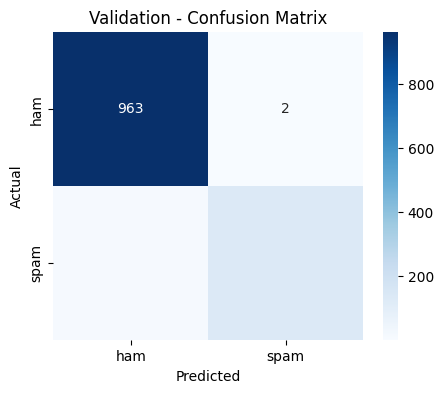

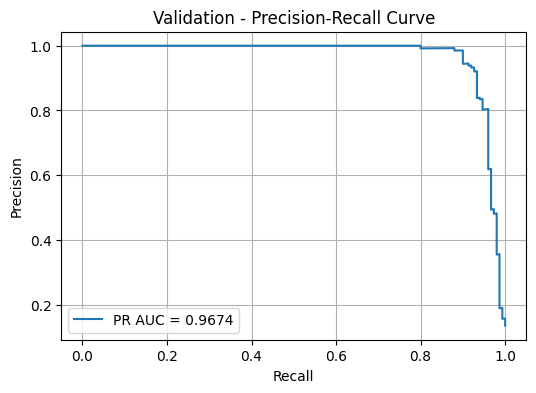

Best parameters: {'alpha': 0.1}
Validation F1-score: 0.9408

Evaluation on Test (Naive Bayes) dataset:
Accuracy: 0.9785
Precision (spam): 0.9921
Recall (spam): 0.8456
F1-score (spam): 0.9130

Confusion Matrix:
[[965   1]
 [ 23 126]]


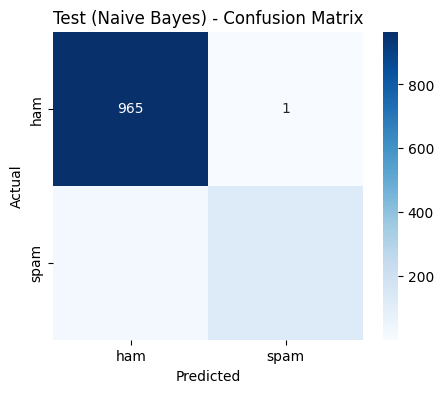

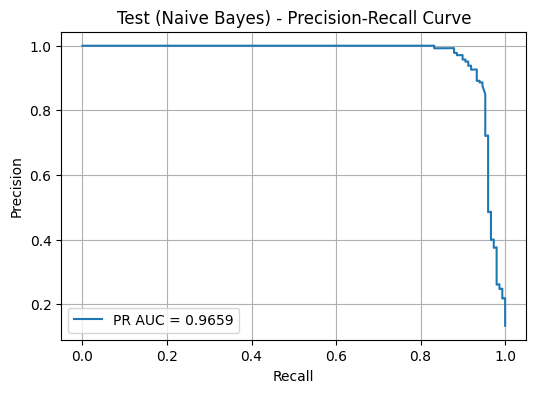

Naive Bayes Test F1-score: 0.9130

Fine-tuning Linear SVM...


C:\Users\Nirjhar Nath\anaconda3\New folder\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation on Validation dataset:
Accuracy: 0.9758
Precision (spam): 0.9424
Recall (spam): 0.8733
F1-score (spam): 0.9066

Confusion Matrix:
[[957   8]
 [ 19 131]]


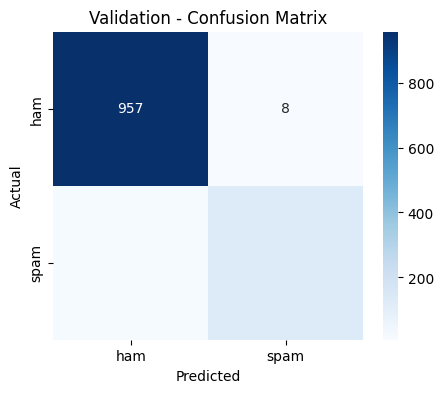

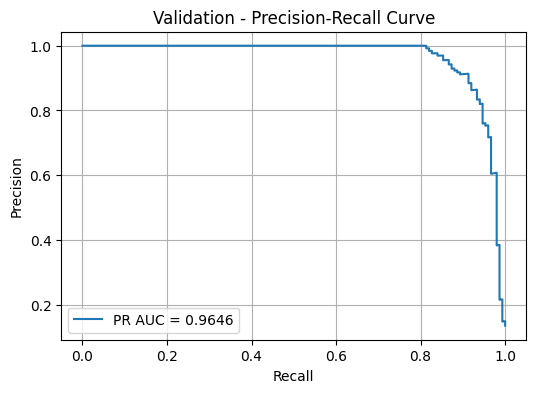

Best parameters: {'C': 10}
Validation F1-score: 0.9066

Evaluation on Test (Linear SVM) dataset:
Accuracy: 0.9830
Precision (spam): 0.9710
Recall (spam): 0.8993
F1-score (spam): 0.9338

Confusion Matrix:
[[962   4]
 [ 15 134]]


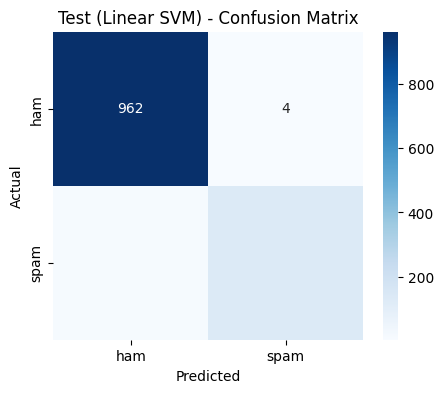

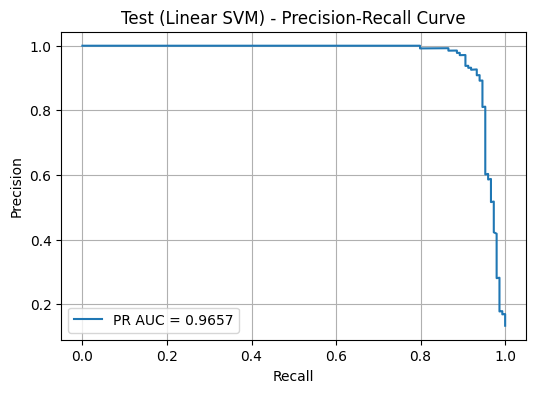

Linear SVM Test F1-score: 0.9338

Fine-tuning Random Forest...

Evaluation on Validation dataset:
Accuracy: 0.9695
Precision (spam): 1.0000
Recall (spam): 0.7733
F1-score (spam): 0.8722

Confusion Matrix:
[[965   0]
 [ 34 116]]


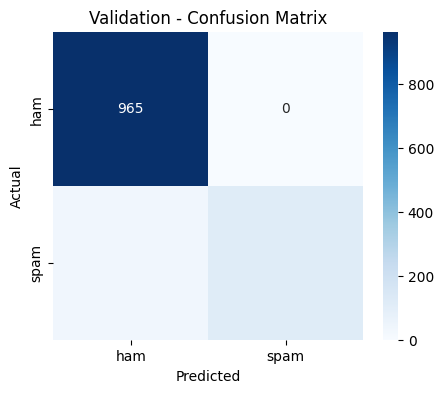

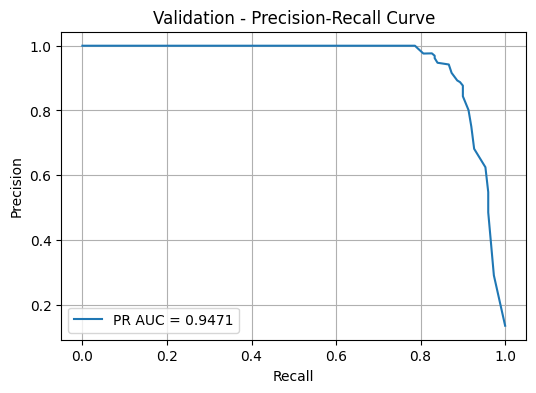

Best parameters: {'max_depth': None, 'n_estimators': 50}
Validation F1-score: 0.8722

Evaluation on Test (Random Forest) dataset:
Accuracy: 0.9668
Precision (spam): 1.0000
Recall (spam): 0.7517
F1-score (spam): 0.8582

Confusion Matrix:
[[966   0]
 [ 37 112]]


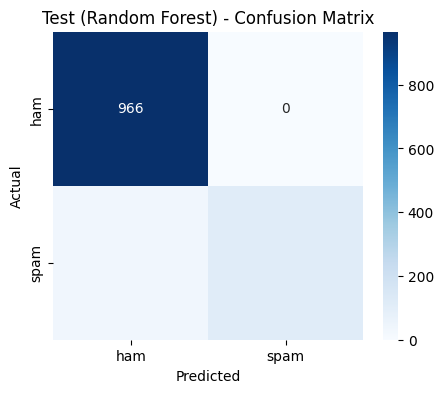

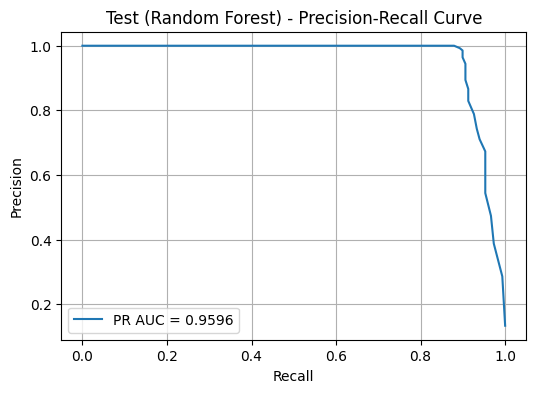

Random Forest Test F1-score: 0.8582

Best model: Linear SVM (F1-score: 0.9338)


In [13]:
def main():
    train_data, validation_data, test_data = load_data()
    best_model, best_vectorizer = benchmark_models(train_data, validation_data, test_data)

if __name__ == "__main__":
    main()

It turns out that Linear SVM is the best model, with the following evaluation metrics:
- Accuracy: 0.9830
- Precision (spam): 0.9710
- Recall (spam): 0.8993
- F1-score (spam): 0.9338
- AUC-PR: 0.9657

#### Cross-verifying that Linear SVM is the best model and saving it as a .pkl file

In [14]:
import pickle
import os
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

In [15]:
def save_model(model, vectorizer, filename='best_model.pkl'):
    """Save model and vectorizer to a pickle file"""
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump((model, vectorizer), f)
    print(f"\n Model saved to {filename}")

In [16]:
def load_model(filename):
    """Load model and vectorizer from a pickle file"""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [17]:
def evaluate_loaded_model(model, vectorizer, test_data):
    """Evaluate the loaded model"""
    test_data = handle_nan_data(test_data)
    X_test = vectorizer.transform(test_data['message'])
    y_test = test_data['label']
    
    predictions = model.predict(X_test)

    print("\n Evaluation on Test Data (Loaded Model):")
    print("Accuracy:", round(accuracy_score(y_test, predictions), 5))
    print("Precision:", round(precision_score(y_test, predictions), 5))
    print("Recall:", round(recall_score(y_test, predictions), 5))
    print("F1 Score:", round(f1_score(y_test, predictions), 5))
    print("PR AUC:", round(average_precision_score(y_test, predictions), 5))


Fine-tuning Naive Bayes...

Evaluation on Validation dataset:
Accuracy: 0.9848
Precision (spam): 0.9854
Recall (spam): 0.9000
F1-score (spam): 0.9408

Confusion Matrix:
[[963   2]
 [ 15 135]]


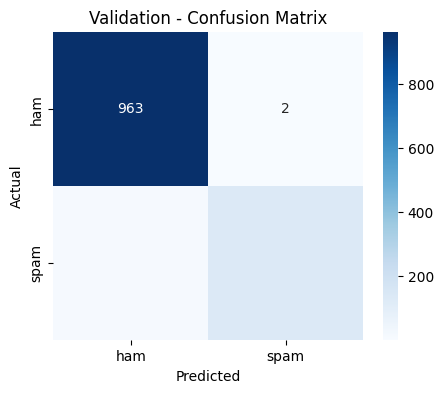

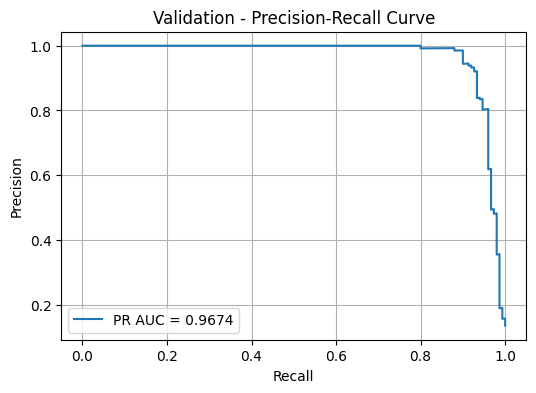

Best parameters: {'alpha': 0.1}
Validation F1-score: 0.9408

Evaluation on Test (Naive Bayes) dataset:
Accuracy: 0.9785
Precision (spam): 0.9921
Recall (spam): 0.8456
F1-score (spam): 0.9130

Confusion Matrix:
[[965   1]
 [ 23 126]]


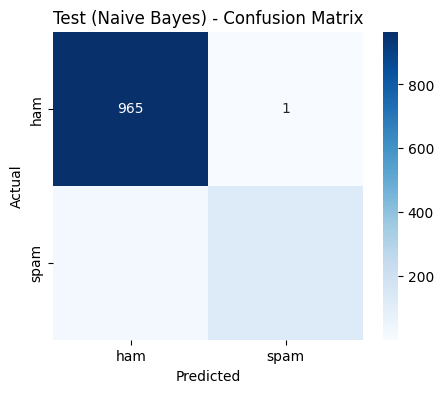

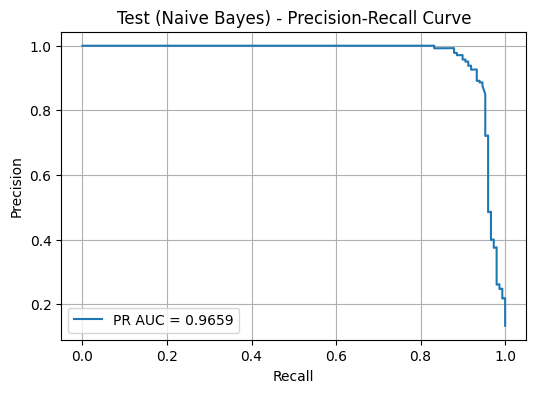

Naive Bayes Test F1-score: 0.9130

Fine-tuning Linear SVM...


C:\Users\Nirjhar Nath\anaconda3\New folder\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation on Validation dataset:
Accuracy: 0.9758
Precision (spam): 0.9424
Recall (spam): 0.8733
F1-score (spam): 0.9066

Confusion Matrix:
[[957   8]
 [ 19 131]]


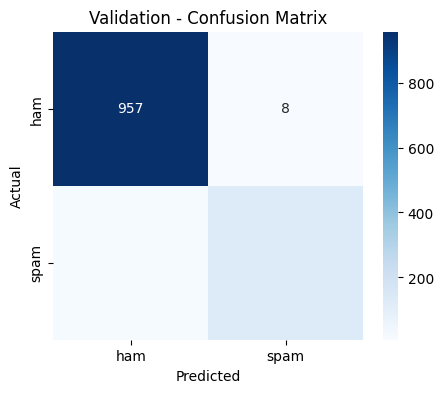

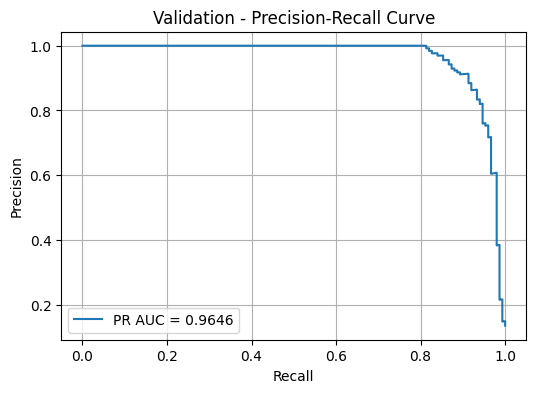

Best parameters: {'C': 10}
Validation F1-score: 0.9066

Evaluation on Test (Linear SVM) dataset:
Accuracy: 0.9830
Precision (spam): 0.9710
Recall (spam): 0.8993
F1-score (spam): 0.9338

Confusion Matrix:
[[962   4]
 [ 15 134]]


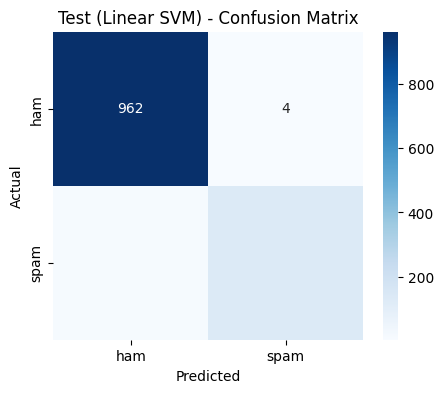

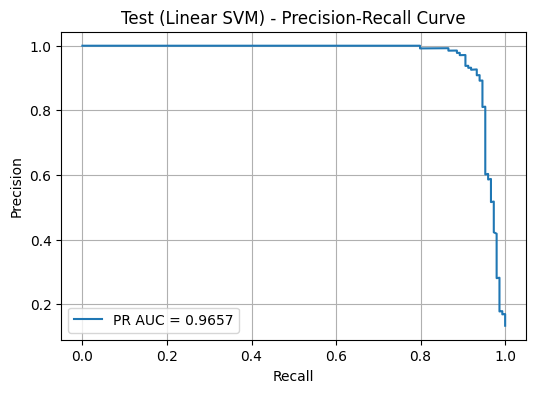

Linear SVM Test F1-score: 0.9338

Fine-tuning Random Forest...

Evaluation on Validation dataset:
Accuracy: 0.9695
Precision (spam): 1.0000
Recall (spam): 0.7733
F1-score (spam): 0.8722

Confusion Matrix:
[[965   0]
 [ 34 116]]


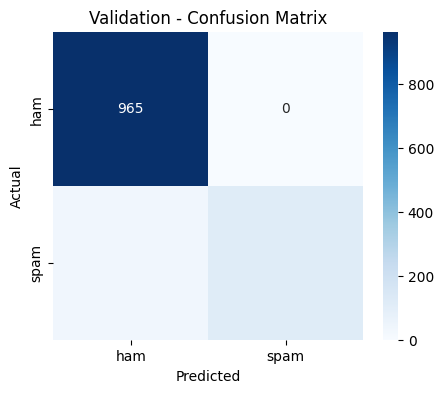

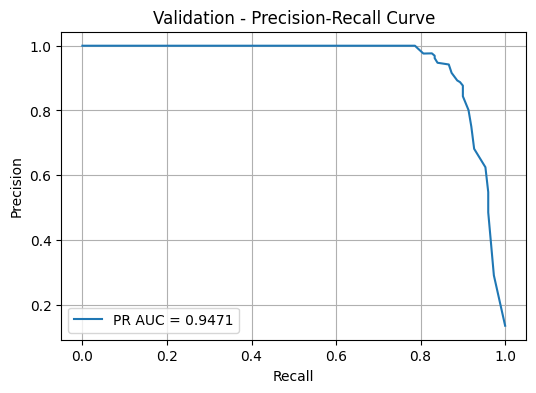

Best parameters: {'max_depth': None, 'n_estimators': 50}
Validation F1-score: 0.8722

Evaluation on Test (Random Forest) dataset:
Accuracy: 0.9668
Precision (spam): 1.0000
Recall (spam): 0.7517
F1-score (spam): 0.8582

Confusion Matrix:
[[966   0]
 [ 37 112]]


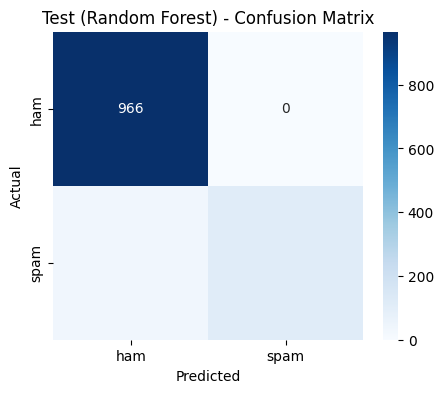

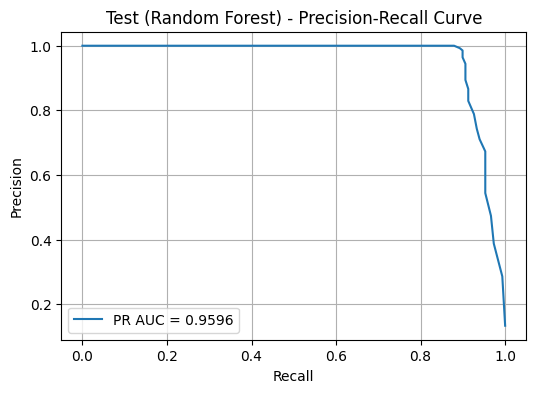

Random Forest Test F1-score: 0.8582

Best model: Linear SVM (F1-score: 0.9338)

 Model saved to model/best_model.pkl

 Evaluation on Test Data (Loaded Model):
Accuracy: 0.98296
Precision: 0.97101
Recall: 0.89933
F1 Score: 0.9338
PR AUC: 0.88671


In [18]:
def main():
    train_data, validation_data, test_data = load_data()
    best_model, best_vectorizer = benchmark_models(train_data, validation_data, test_data)

    # Save the best model
    model_path = 'model/best_model.pkl'
    save_model(best_model, best_vectorizer, model_path)

    # Load and evaluate
    loaded_model, loaded_vectorizer = load_model(model_path)
    evaluate_loaded_model(loaded_model, loaded_vectorizer, test_data)

if __name__ == "__main__":
    main()